# EDA Notebook

## Data Understanding

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import stats
import data_preparation as dp
import figures as fg
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')
%matplotlib inline

In [2]:
# Load Kings county database and preview first few entries
kc_df = pd.read_csv('data/kc_house_data.csv')
kc_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Taking a look at all the columns, data types, and missing entries
kc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The data contains 21 total columns, 12 of type int or float, and 6 of type object. It contains:

- `id` column which have a unique id value for each house
- `date` column with the sale date (Years 2014 - 2015)
- `price` column with the price of sale and our target variable
    - <p>mean: \$540296</p>
    - <p>std: \$367368</p>
- `bedrooms`, `bathrooms` and `floors` columns with counts of each in their respective house
- four area variables defining the square footage of living space, lot space, area of house apart from the basement, and area of the basement.
- two area variables describing the living and lot area of the 15 nearest neighbors
- `waterfront` variable of whether the house is on a waterfront (Yes/No)
- `view` describing quality of view from house
    - (None, Fair, Average, Good, Excellent)
- `condition` for the overall maintanence condition of the house
    - (Poor, Fair, Average, Good, Very Good)
- `grade` describing overall construction and design grade of the house 
    - (Poor, Low, Fair, Low Average, Average, Good, Better, Very Good, Excellent, Luxury, Mansion)
- `yr_built` for when the house was built
- `yr_renovated` for when house was renovated last (if applicable)
- three location columns detailing `zipcode`, latitude (`lat`) and longitude (`long`) of the house.
    - Our data consists of an area covering 70 zipcodes


In [4]:
# Checking the years spanned by the data set
sales_year = kc_df.date.map(lambda x: int(x[-4:]))

print('The data spans the years {} to {}'.format(min(sales_year), max(sales_year)))

# finds mean and standard deviation of price
print('Sales price mean: ${}, stdev: ${}'.format(int(kc_df.price.mean()),int(kc_df.price.std())))

The data spans the years 2014 to 2015
Sales price mean: $540296, stdev: $367368


In [5]:
# Checking view values
kc_df.view.value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [6]:
# Checking condition values
kc_df.condition.value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [7]:
# Checking grade values
kc_df.grade.value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [8]:
# Checking how many unique zipcodes are included in the dataset
num_of_zip = len(kc_df.zipcode.unique())
print('There are {} unique zipcodes in this data set'.format(num_of_zip))

There are 70 unique zipcodes in this data set


## Data Preparation


At first glance, the columns for `id`, latitude (`lat`), and longitude (`long`) can be removed. The `id` column is good for reference, but not good for a linear regression model. The latitude and longitude appear to be difficult variables to deal with since they describe an exact location. In a linear regression model their seperate coefficients would only be good for how far in a cordinal direction they are. Having zones like a zipcode would be preferable as that defines a region, though having a 70 unique zipcodes in our data set would create a lot of columns if they were treated categorically and one hot encoded. Therefore the `zipcode` column will also be ommitted from our calculations. Another column that can be removed is the `date`. If our data set spanned a longer time this column may be used to adjust for inflation, or observe outside conditions that caused housing prices to drastically change like the 2006 housing bubble. Since our data only spans the years of 2014 and 2015 this isn't necessary.

We also have to consider which columns can actually pertain to our problem. We are looking for the best variables to improve to increase the sales price. Variables like `waterfront`, `sqft_lot`, `view`, `yr_built`, `yr_renovated`, `sqft_basement`, `sqft_living15` and `sqft_lot15` are variables that depend on location or are hard to change. Considering that these variables are most likely impossible to change, they will also be ommitted from our calculations.

Another thing to consider is correlation between features. Looking at the feature descriptions `sqft_living` and `sqft_above` may be very similar. Let's check their correlations.

In [9]:
kc_df[['sqft_living', 'sqft_above']].corr().iloc[0, 1]

0.8764477590354868

There's some clear correlation between them, and seeing as most living space is above the basement this most likely isn't spurious correlation. Therefore one of the variables should be dropped from the analysis. 

In [10]:
# Dropping unnecessary columns from original dataset
unn_columns = ['id', 'date', 'lat', 'long', 'zipcode', 'waterfront',
               'view', 'yr_built', 'yr_renovated', 'sqft_living15',
              'sqft_lot15', 'sqft_lot', 'sqft_basement', 'sqft_above']

kc_df_iprep = kc_df.drop(columns=unn_columns, axis=1).copy()
kc_df_iprep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   floors       21597 non-null  float64
 5   condition    21597 non-null  object 
 6   grade        21597 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 1.2+ MB


We now need to handle the object columns. 

The `grade` columns values already have a numerical ranking assigned to them followed by the description. Therefore we will just remove the description for each.

The `condition` column only contains the description, so they will be replaced using the map below.

- Poor: 1
- Fair: 2
- Average: 3
- Good: 4
- Very Good: 5

The mapping data will be saved for later reference.

In [11]:
kc_df_iprep, condition_map, grade_map = dp.initial_prep(kc_df_iprep)
kc_df_iprep.head()

,price,bedrooms,bathrooms,sqft_living,floors,condition,grade
0,221900.0,3,1.00,1180,1.0,3,7
1,538000.0,3,2.25,2570,2.0,3,7
2,180000.0,2,1.00,770,1.0,3,6
3,604000.0,4,3.00,1960,1.0,5,7
4,510000.0,3,2.00,1680,1.0,3,8


Let's look at the data to check for any outliers in the data.

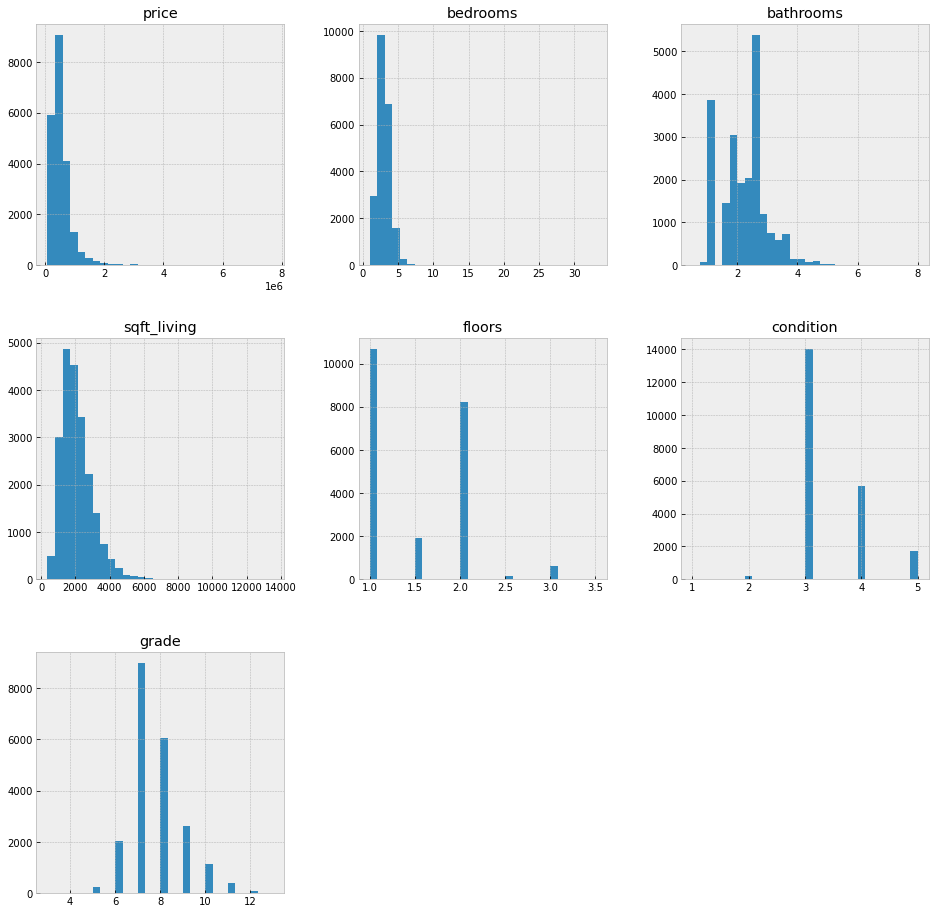

In [12]:
kc_df_iprep.hist(figsize=(16,16), bins=30);

There appears to be some outliers in the `bedrooms`, `sqft_living` and `price` columns. we will call outliers in `sqft_living` and `price` anything about 8,000 and 4,000,000 respectively. Let's take a look at bedroom values. 

In [13]:
kc_df_iprep.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

There's one entry of 33 bedrooms that is much larger than the rest that will be ommitted.

In [14]:
len_of_outliers = len(kc_df_iprep[(kc_df_iprep.sqft_living > 8000)
                              | (kc_df_iprep.price > 4000000)
                              | (kc_df_iprep.bedrooms == 33)])
print('Percentage of outliers: {}%'.format(round(100*(len_of_outliers/len(kc_df_iprep)), 4)))

Percentage of outliers: 0.0695%


These outliers only account for about .07% of the data, thus will be omitted. While ommitting these entries duplicates will also be checked for and dropped.

In [15]:
kc_df_iprep = dp.omit_outliers_dups(kc_df_iprep)

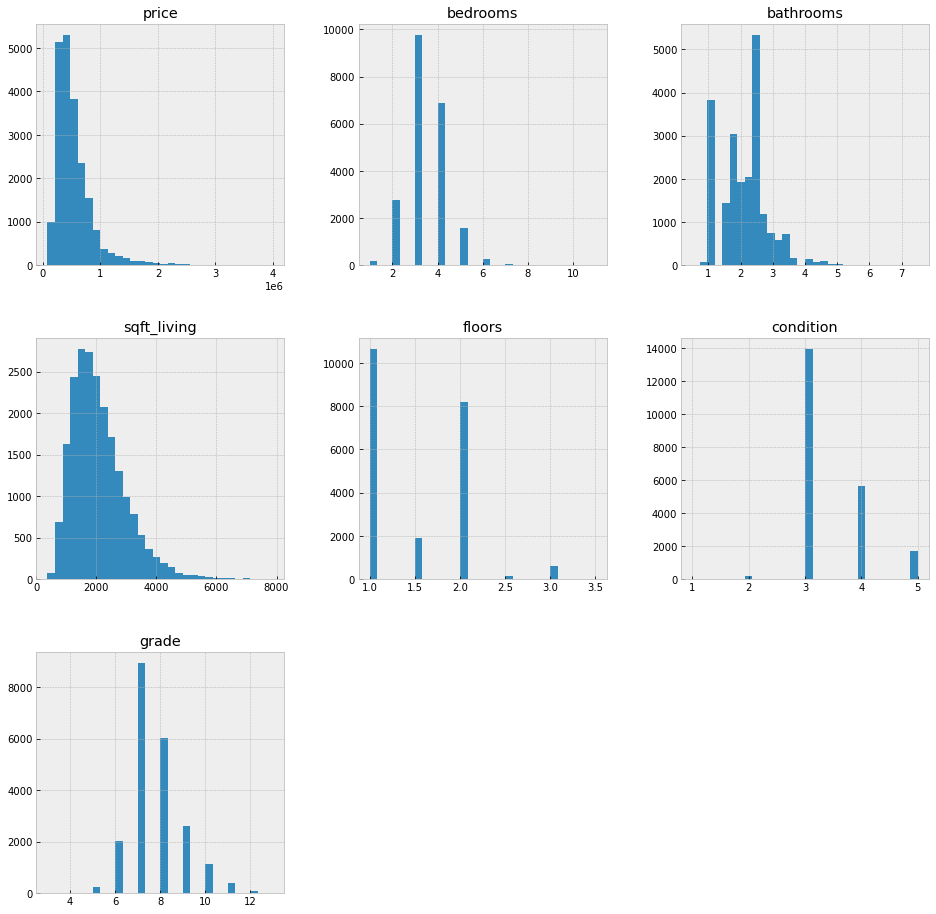

In [16]:
kc_df_iprep.hist(figsize=(16,16), bins=30);

Though the columns for `bedrooms`, `bathrooms`, `condition` and `grade` look like categories that can possible be One Hot Encoded, it will be difficult to make a suggestion based on the individual coefficients for each subcategory. Thus they will be treated as continuous features, they have already been encoded with appropriate numerical values.

With the initial prep done, let's split the dataset into a training and test set to later see if our models properly represent the data.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# Target Variable
y = kc_df_iprep.price.copy()

# independent variables
X = kc_df_iprep.drop(columns='price', axis=1).copy()

# Splits the data into two sets at a 4:1 ratio of variables for train:test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

## Modeling

The initial data preparation is completed, it's time to start our first model which will be a simple linear regression of the variable with the highest correlation to price.

### Base Model


In [19]:
# Checks correlation of all variables to price
pd.concat([X_train, y_train], axis=1).corr().price.sort_values(ascending=False)

price          1.000000
sqft_living    0.693351
grade          0.676487
bathrooms      0.520193
bedrooms       0.312859
floors         0.265260
condition      0.038695
Name: price, dtype: float64

The variable with the highest correlation to `price` is `sqft_living`. Let's take a look at the scatter plot and histograms for the variables.

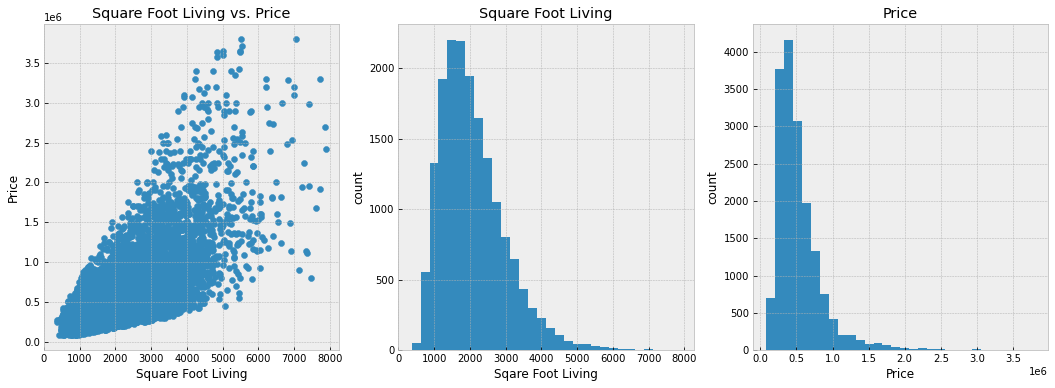

In [20]:
# Creates basemodel x_train
fg.base_plots(X_train.sqft_living, y_train)

The histograms for square foot living and price show that the data is a bit skewed to the left. If our model performs poorly maybe we can check if the log of these variable will perform better. Our analysis cross validates are variables using a shuffle split that created ten random samples of training and test sets from our training set. The scores reported below are the average R<sup>2</sup> values for both sets.

In [21]:
base_results = dp.cross_val(X_train[['sqft_living']], y_train)
print('Baseline Train Rsquared Score: {}'.format(round(base_results['train_score'].mean(), 5)))
print('Baseline Test Rsquared Score: {}'.format(round(base_results['test_score'].mean(), 5)))

Baseline Train Rsquared Score: 0.48122
Baseline Test Rsquared Score: 0.47789


The resulting R<sup>2</sup> score has our modeling explaining only 48% of of our target variables variance. The Train and Test scores also very close. This shows that this model is underfit with a large bias and low variance. Let's take a quick look at the logs of these variables and the resulting model.

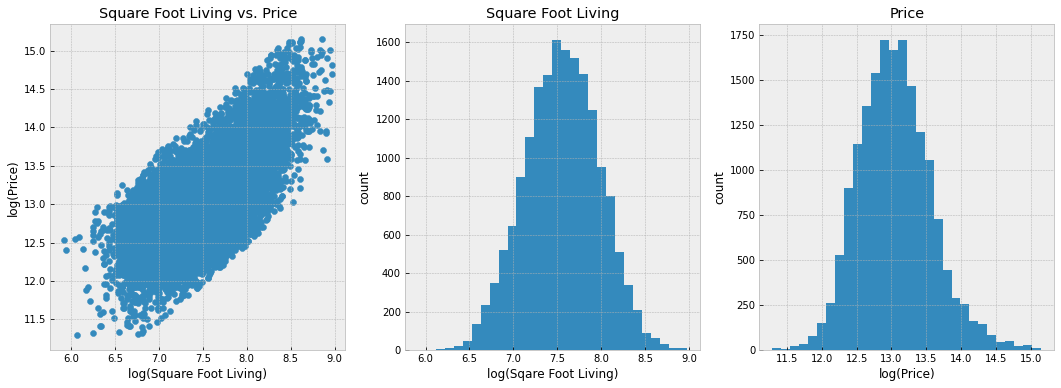

In [22]:
# Plots the log transformed figures
fg.base_plots_log(X_train.sqft_living, y_train)

It appears that the log of both variables is very similar to a normal distribution. Let's now test the linear regression model created from these variables.

In [48]:
base_results_log = dp.cross_val(np.log(X_train[['sqft_living']]), np.log(y_train))
print('Baseline log Train Rsquared Score: {}'.format(round(base_results_log['train_score'].mean(), 5)))
print('Baseline log Test Rsquared Score: {}'.format(round(base_results_log['test_score'].mean(), 5)))

Baseline log Train Rsquared Score: 0.45292
Baseline log Test Rsquared Score: 0.45266


The R<sup>2</sup> scores have actually gone down compared to our original model, only explaining around 45% or our target variables variance. Therefore the previous model will be kept as our baseline model. 

### Model 2 - With all Features

Let's cross validate the model when we use all the features. 

In [24]:
model2_results = dp.cross_val(X_train, y_train)
print('Second Model Train Rsquared Score: {}'.format(round(model2_results['train_score'].mean(), 5)))
print('Second Model Test Rsquared Score: {}\n'.format(round(model2_results['test_score'].mean(), 5)))

print('Baseline log Train Rsquared Score: {}'.format(round(base_results_log['train_score'].mean(), 5)))
print('Baseline log Test Rsquared Score: {}'.format(round(base_results_log['test_score'].mean(), 5)))

Second Model Train Rsquared Score: 0.55422
Second Model Test Rsquared Score: 0.55353

Baseline log Train Rsquared Score: 0.45292
Baseline log Test Rsquared Score: 0.45266


There is some clear improvement in the R<sup>2</sup> values of our second model. This model now explains around 55% of our target variables variance. While we did improve our bias by a decent amount, it is still pretty high. Our training and test scores are also still very close so our variance is low. This means we still have a pretty underfit model.

Like the previous model, some features may benefit from a log functin. Looking at the histograms above these features are `sqft_living`, `bedrooms`, and `bathrooms`. The target variable `price` can also benefit from a log function.

In [49]:
log_cols = ['sqft_living', 'bedrooms', 'bathrooms']

X_train_log = X_train.copy()
X_train_log[log_cols] = np.log(X_train_log[log_cols])

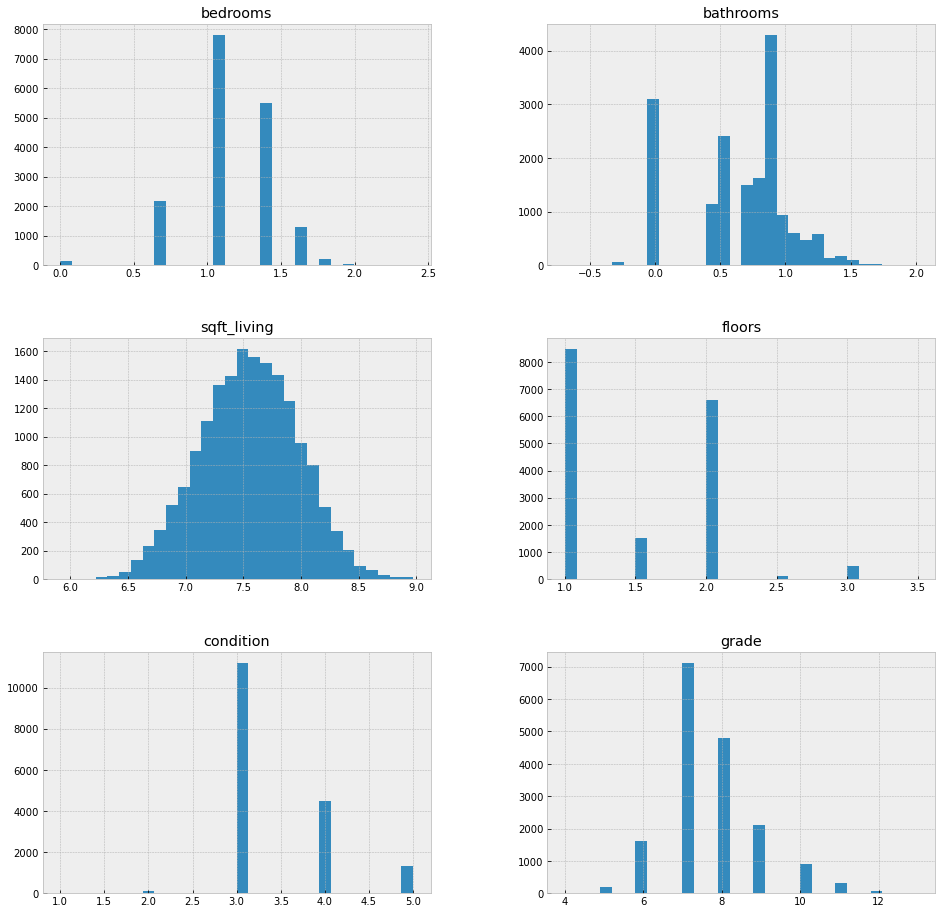

In [53]:
X_train_log.hist(figsize=(16,16), bins=30);

In [54]:
model2_log_results = dp.cross_val(X_train_log, np.log(y_train))
print('Second Model Train Rsquared Score: {}'.format(round(model2_log_results['train_score'].mean(), 5)))
print('Second Model Test Rsquared Score: {}\n'.format(round(model2_log_results['test_score'].mean(), 5)))

print('Second Model Train Rsquared Score: {}'.format(round(model2_results['train_score'].mean(), 5)))
print('Second Model Test Rsquared Score: {}\n'.format(round(model2_results['test_score'].mean(), 5)))

print('Baseline log Train Rsquared Score: {}'.format(round(base_results_log['train_score'].mean(), 5)))
print('Baseline log Test Rsquared Score: {}'.format(round(base_results_log['test_score'].mean(), 5)))

Second Model Train Rsquared Score: 0.56431
Second Model Test Rsquared Score: 0.56459

Second Model Train Rsquared Score: 0.55422
Second Model Test Rsquared Score: 0.55353

Baseline log Train Rsquared Score: 0.45292
Baseline log Test Rsquared Score: 0.45266


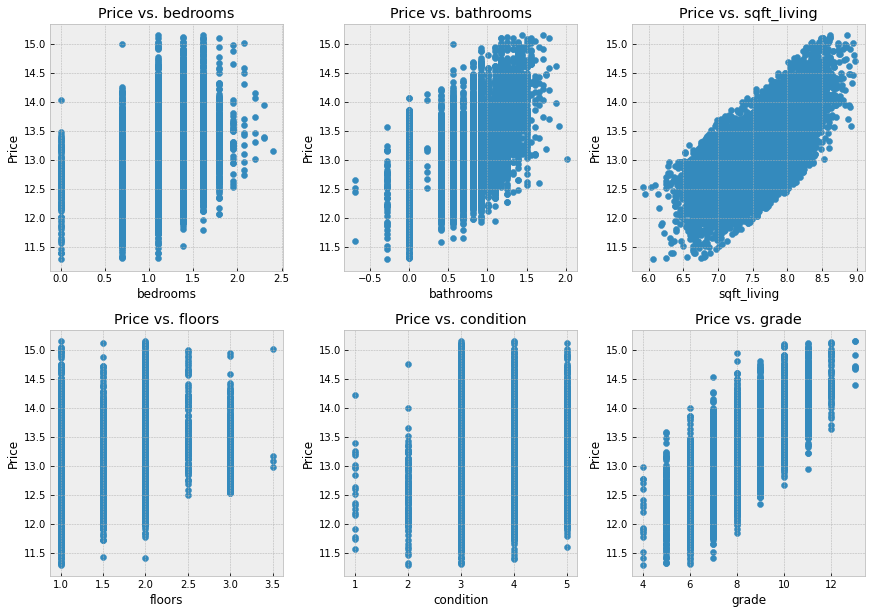

In [57]:
fg.all_scatters(X_train_log, np.log(y_train))

In [58]:
predictors = sm.add_constant(X_train_log)
model = sm.OLS(np.log(y_train), predictors).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     3710.
Date:                Tue, 06 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:39:58   Log-Likelihood:                -6134.8
No. Observations:               17184   AIC:                         1.228e+04
Df Residuals:                   17177   BIC:                         1.234e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.3835      0.077     96.480      0.000       7.234       7.534
bedrooms       -0.1682      0.013    -13.337      0.000      -0.193      -0.143
bathrooms      -0.0581      0.011     -5.152      0.000      -0.080      -0.036
sqft_living     0.5240      0.013     40.798      0.000       0.499       0.549
floors          0.0163      0.006      2.720      0.007       0.005       0.028
condition       0.1029      0.004     24.243      0.000       0.095       0.111
grade           0.2051      0.004     56.766      0.000       0.198       0.212
==============================================================================
Omnibus:                       52.218   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.619
Skew:                           0.135   Prob(JB):                     3.75e-12
Kurtosis:                       3.019   Cond. No.                         341.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's check for correlation between features.

In [38]:
def correlation_check(X_train):
#     Create correlation matrix, manipulate them into one column
    df = X_train.corr().stack().reset_index().sort_values(0, ascending=False)
    
#     Creates variables for new index
    df['pairs'] = list(zip(df.level_0, df.level_1))

#     Sets new index to pairs
    df.set_index(['pairs'], inplace = True)

    #drops level columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    # rename correlation column as cc rather than 0
    df.columns = ['cc']

    # drop duplicates.
    df.drop_duplicates(inplace=True)
    return df[(df.cc>.3) & (df.cc <1)]
    

In [39]:
model2_corr = correlation_check(X_train)
model2_corr

,cc
pairs,
"(grade, sqft_living)",0.765227
"(bathrooms, sqft_living)",0.754150
"(bathrooms, grade)",0.663297
"(sqft_living, bedrooms)",0.590357
"(bathrooms, bedrooms)",0.527167
"(bathrooms, floors)",0.504449
"(floors, grade)",0.460983
"(floors, sqft_living)",0.359470
"(bedrooms, grade)",0.356576


It appears the column `sqft_living` has high correlation with a lot of features. Let's try a model without it.

In [45]:
model_temp = X_train.drop(columns='bathrooms', axis=1)

modeltemp_results = dp.cross_val(model_temp, y_train)
print('Second Model Train Rsquared Score: {}'.format(round(modeltemp_results['train_score'].mean(), 5)))
print('Second Model Test Rsquared Score: {}\n'.format(round(modeltemp_results['test_score'].mean(), 5)))

Second Model Train Rsquared Score: 0.55397
Second Model Test Rsquared Score: 0.55339



In [46]:
predictors = sm.add_constant(model_temp)
model = sm.OLS(y_train, predictors).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     4268.
Date:                Tue, 06 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:12:14   Log-Likelihood:            -2.3687e+05
No. Observations:               17184   AIC:                         4.738e+05
Df Residuals:                   17178   BIC:                         4.738e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.541e+05   1.98e+04    -37.999      0.000   -7.93e+05   -7.15e+05
bedrooms    -4.074e+04   2485.418    -16.393      0.000   -4.56e+04   -3.59e+04
sqft_living   190.2210      3.615     52.626      0.000     183.136     197.306
floors      -2.008e+04   3840.145     -5.228      0.000   -2.76e+04   -1.25e+04
condition     6.38e+04   2877.025     22.177      0.000    5.82e+04    6.94e+04
grade        1.106e+05   2536.638     43.598      0.000    1.06e+05    1.16e+05
==============================================================================
Omnibus:                     9640.401   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           152119.436
Skew:                           2.366   Prob(JB):                         0.00
Kurtosis:                      16.786   Cond. No.                     2.54e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 3 - Interactions between all Variables

For model three some feature interactions will be created. Let's take a closer look at our independant variables related to price through scatter plots to see if any features look parabolic.

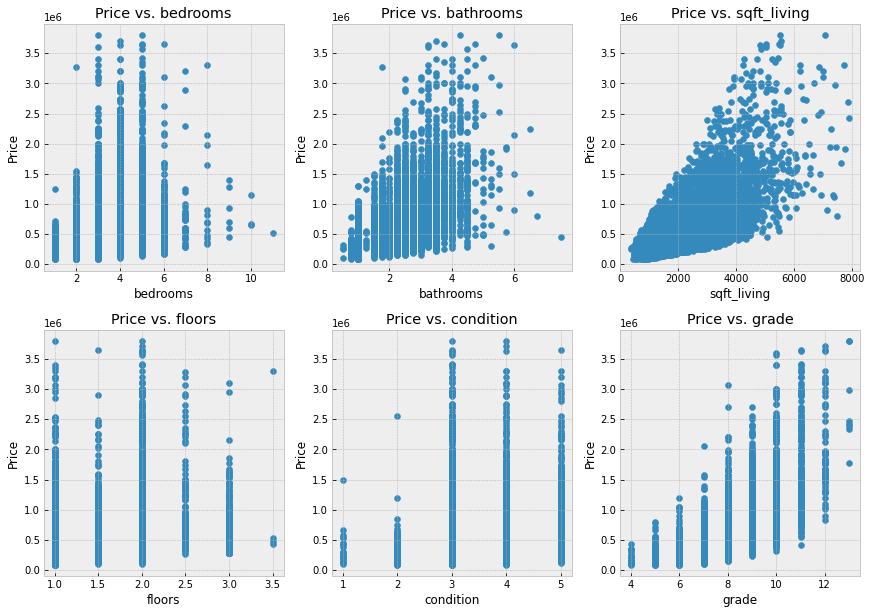

In [25]:
fg.all_scatters(X_train, y_train)

None of the variables appear to have an exponential relationship to price, so only interactions between variables will be tested.

In [26]:
# Creates training set with continuous variables interactions
X_train_model3 = dp.create_interactions(X_train)
X_train_model3.head()

,bedrooms,bathrooms,sqft_living,floors,condition,grade,bedrooms*bathrooms,bedrooms*sqft_living,bedrooms*floors,bedrooms*condition,...,bathrooms*sqft_living,bathrooms*floors,bathrooms*condition,bathrooms*grade,sqft_living*floors,sqft_living*condition,sqft_living*grade,floors*condition,floors*grade,condition*grade
8825,3.0,2.00,1530.0,1.0,4.0,7.0,6.00,4590.0,3.0,12.0,...,3060.0,2.00,8.00,14.00,1530.0,6120.0,10710.0,4.0,7.0,28.0
17364,3.0,1.00,1010.0,1.0,3.0,6.0,3.00,3030.0,3.0,9.0,...,1010.0,1.00,3.00,6.00,1010.0,3030.0,6060.0,3.0,6.0,18.0
12870,4.0,1.75,1440.0,1.0,4.0,7.0,7.00,5760.0,4.0,16.0,...,2520.0,1.75,7.00,12.25,1440.0,5760.0,10080.0,4.0,7.0,28.0
1232,2.0,1.00,790.0,1.0,4.0,6.0,2.00,1580.0,2.0,8.0,...,790.0,1.00,4.00,6.00,790.0,3160.0,4740.0,4.0,6.0,24.0
11766,3.0,1.75,1210.0,1.0,3.0,7.0,5.25,3630.0,3.0,9.0,...,2117.5,1.75,5.25,12.25,1210.0,3630.0,8470.0,3.0,7.0,21.0


We can use the same function used for model2 to see how these new variables perform.

In [27]:
model3_results = dp.cross_val(X_train_model3, y_train)

print('Second Model Train Rsquared Score: {}'.format(round(model3_results['train_score'].mean(), 5)))
print('Second Model Test Rsquared Score: {}\n'.format(round(model3_results['test_score'].mean(), 5)))

print('Second Model Train Rsquared Score: {}'.format(round(model2_results['train_score'].mean(), 5)))
print('Second Model Test Rsquared Score: {}\n'.format(round(model2_results['test_score'].mean(), 5)))

print('Baseline log Train Rsquared Score: {}'.format(round(base_results_log['train_score'].mean(), 5)))
print('Baseline log Test Rsquared Score: {}'.format(round(base_results_log['test_score'].mean(), 5)))

Second Model Train Rsquared Score: 0.60896
Second Model Test Rsquared Score: 0.60552

Second Model Train Rsquared Score: 0.55422
Second Model Test Rsquared Score: 0.55353

Baseline log Train Rsquared Score: 0.45292
Baseline log Test Rsquared Score: 0.45266


The third model shows a lot of improvement on the second model, accounting for around 61% of our target variables variance. Though similarly to the previous models the bias is still pretty large and variance small meaning it is still underfit.

### Model 4 -  Recursive Feature Elimination

Let's try seeing if using a recursive feature elimination function on model 3 will give us an improved model. This function will start will all features, and iteratively remove one feature until that models score is lower than the previous.

In [28]:
model4_in, model4_out = dp.recursive_elimination(X_train_model3, y_train)

In [29]:
model4_in

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'condition',
 'grade',
 'bedrooms*bathrooms',
 'bedrooms*floors',
 'bedrooms*condition',
 'bedrooms*grade',
 'bathrooms*sqft_living',
 'bathrooms*condition',
 'bathrooms*grade',
 'sqft_living*floors',
 'sqft_living*condition',
 'sqft_living*grade',
 'floors*condition',
 'floors*grade',
 'condition*grade']

In [30]:
model4_out

['bedrooms*sqft_living', 'bathrooms*floors']

It appears we have only lost two columns through recursive feature elimination, `bedrooms*sqft_living` and `bathrooms*floors`. Let's take a look at how the selected columns perform.

In [31]:
# Drops columns that didn't survive recursive feature elimination
X_train_model4 = X_train_model3.drop(columns=model4_out, axis=1)

# Finds Rsquared values through cross validation
model4_results = dp.cross_val(X_train_model4, y_train)

print('Second Model Train Rsquared Score: {}'.format(round(model4_results['train_score'].mean(), 5)))
print('Second Model Test Rsquared Score: {}\n'.format(round(model4_results['test_score'].mean(), 5)))

print('Second Model Train Rsquared Score: {}'.format(round(model3_results['train_score'].mean(), 5)))
print('Second Model Test Rsquared Score: {}\n'.format(round(model3_results['test_score'].mean(), 5)))

print('Second Model Train Rsquared Score: {}'.format(round(model2_results['train_score'].mean(), 5)))
print('Second Model Test Rsquared Score: {}\n'.format(round(model2_results['test_score'].mean(), 5)))

print('Baseline log Train Rsquared Score: {}'.format(round(base_results_log['train_score'].mean(), 5)))
print('Baseline log Test Rsquared Score: {}'.format(round(base_results_log['test_score'].mean(), 5)))

Second Model Train Rsquared Score: 0.60895
Second Model Test Rsquared Score: 0.60558

Second Model Train Rsquared Score: 0.60896
Second Model Test Rsquared Score: 0.60552

Second Model Train Rsquared Score: 0.55422
Second Model Test Rsquared Score: 0.55353

Baseline log Train Rsquared Score: 0.45292
Baseline log Test Rsquared Score: 0.45266


The fourth model didn't perform any better than the third model. Though with less features it is less complicated of a model and will be used in preference to the third model.

In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

predictors = sm.add_constant(X_train_model4)
model = sm.OLS(y_train, predictors).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     1405.
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:49:43   Log-Likelihood:            -2.3575e+05
No. Observations:               17184   AIC:                         4.715e+05
Df Residuals:                   17164   BIC:                         4.717e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.175e+06   1.06e+05     11.118      0.000    9.68e+05    1.38e+06
bedrooms                5.79e+04   2.06e+04      2.810      0.005    1.75e+04    9.83e+04
bathrooms             -3.042e+05   3.56e+04     -8.538      0.000   -3.74e+05   -2.34e+05
sqft_living            -223.4142     30.873     -7.237      0.000    -283.929    -162.900
floors                -1.707e+05   4.45e+04     -3.836      0.000   -2.58e+05   -8.35e+04
condition             -2.453e+05   2.38e+04    -10.327      0.000   -2.92e+05   -1.99e+05
grade                 -8.934e+04   1.72e+04     -5.185      0.000   -1.23e+05   -5.56e+04
bedrooms*bathrooms     1.544e+04   3155.652      4.893      0.000    9255.321    2.16e+04
bedrooms*floors        1.167e+04   5291.148      2.205      0.027    1295.432     2.2e+04
bedrooms*condition    -8896.5245   3655.116     -2.434      0.015   -1.61e+04   -1732.124
bedrooms*grade         -1.25e+04   2408.411     -5.190      0.000   -1.72e+04   -7778.715
bathrooms*sqft_living    -8.3853      4.267     -1.965      0.049     -16.749      -0.022
bathrooms*condition    4745.5769   5710.755      0.831      0.406   -6448.087    1.59e+04
bathrooms*grade         3.34e+04   3729.607      8.956      0.000    2.61e+04    4.07e+04
sqft_living*floors      -27.3325      7.117     -3.840      0.000     -41.283     -13.382
sqft_living*condition    38.9618      6.013      6.480      0.000      27.176      50.748
sqft_living*grade        36.7535      2.386     15.404      0.000      32.077      41.430
floors*condition       5.302e+04   6972.076      7.604      0.000    3.94e+04    6.67e+04
floors*grade           2468.7574   5056.485      0.488      0.625   -7442.470    1.24e+04
condition*grade         2.53e+04   3868.950      6.540      0.000    1.77e+04    3.29e+04
==============================================================================
Omnibus:                     8396.271   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           126445.376
Skew:                           1.975   Prob(JB):                         0.00
Kurtosis:                      15.689   Cond. No.                     1.47e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
predictors = sm.add_constant(X_train_model3)
model = sm.OLS(y_train, predictors).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     1271.
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:42:29   Log-Likelihood:            -2.3575e+05
No. Observations:               17184   AIC:                         4.715e+05
Df Residuals:                   17162   BIC:                         4.717e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.172e+06   1.07e+05     11.004      0.000    9.63e+05    1.38e+06
bedrooms               5.993e+04   2.19e+04      2.732      0.006    1.69e+04    1.03e+05
bathrooms             -3.049e+05   3.63e+04     -8.400      0.000   -3.76e+05   -2.34e+05
sqft_living            -224.8753     31.419     -7.157      0.000    -286.459    -163.291
floors                -1.705e+05   4.49e+04     -3.799      0.000   -2.59e+05   -8.26e+04
condition             -2.454e+05   2.38e+04    -10.326      0.000   -2.92e+05   -1.99e+05
grade                 -8.875e+04   1.75e+04     -5.062      0.000   -1.23e+05   -5.44e+04
bedrooms*bathrooms     1.497e+04   3597.259      4.163      0.000    7923.729     2.2e+04
bedrooms*sqft_living      0.9947      3.675      0.271      0.787      -6.209       8.199
bedrooms*floors        1.171e+04   5378.772      2.176      0.030    1163.675    2.22e+04
bedrooms*condition    -9004.1684   3678.938     -2.447      0.014   -1.62e+04   -1793.074
bedrooms*grade        -1.288e+04   2801.525     -4.598      0.000   -1.84e+04   -7390.732
bathrooms*sqft_living    -8.7837      4.520     -1.943      0.052     -17.643       0.076
bathrooms*floors         -5.3291   7399.416     -0.001      0.999   -1.45e+04    1.45e+04
bathrooms*condition    4901.7497   5831.668      0.841      0.401   -6528.916    1.63e+04
bathrooms*grade        3.375e+04   4069.703      8.294      0.000    2.58e+04    4.17e+04
sqft_living*floors      -27.2373      7.509     -3.627      0.000     -41.955     -12.519
sqft_living*condition    38.7610      6.077      6.378      0.000      26.849      50.673
sqft_living*grade        36.6843      2.456     14.934      0.000      31.870      41.499
floors*condition       5.303e+04   7018.441      7.556      0.000    3.93e+04    6.68e+04
floors*grade           2387.6078   5112.895      0.467      0.641   -7634.189    1.24e+04
condition*grade        2.537e+04   3889.141      6.524      0.000    1.77e+04     3.3e+04
==============================================================================
Omnibus:                     8397.407   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           126494.921
Skew:                           1.975   Prob(JB):                         0.00
Kurtosis:                      15.691   Cond. No.                     1.59e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
predictors = sm.add_constant(X_train)
model = sm.OLS(y_train, predictors).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     3560.
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:43:01   Log-Likelihood:            -2.3687e+05
No. Observations:               17184   AIC:                         4.738e+05
Df Residuals:                   17177   BIC:                         4.738e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.572e+05   1.99e+04    -38.114      0.000   -7.96e+05   -7.18e+05
bedrooms    -3.916e+04   2538.277    -15.430      0.000   -4.41e+04   -3.42e+04
bathrooms   -1.201e+04   3944.169     -3.046      0.002   -1.97e+04   -4283.756
sqft_living   195.0414      3.945     49.440      0.000     187.309     202.774
floors        -1.6e+04   4066.052     -3.934      0.000    -2.4e+04   -8027.870
condition    6.353e+04   2877.749     22.076      0.000    5.79e+04    6.92e+04
grade        1.116e+05   2558.692     43.627      0.000    1.07e+05    1.17e+05
==============================================================================
Omnibus:                     9645.392   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           153046.021
Skew:                           2.366   Prob(JB):                         0.00
Kurtosis:                      16.833   Cond. No.                     2.55e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Final Model

In [33]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

predictors = sm.add_constant(X_train_final)
model = sm.OLS(y_train, predictors).fit()

model.summary()

NameError: name 'X_train_final' is not defined

In [34]:
df = X_train_model4.corr().stack().reset_index().sort_values(0, ascending=False)
df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)
df[(df.cc>.3) & (df.cc <1)]

,cc
pairs,
"(sqft_living, sqft_living*grade)",0.973421
"(bathrooms*grade, bathrooms)",0.954223
"(floors*grade, floors)",0.944640
"(bathrooms*sqft_living, sqft_living*grade)",0.936915
"(sqft_living, bathrooms*sqft_living)",0.933873
...,...
"(sqft_living, floors*condition)",0.337570
"(bedrooms*bathrooms, condition*grade)",0.331918
"(floors, bathrooms*condition)",0.329545


In [36]:
X_train_model4.corr()

,bedrooms,bathrooms,sqft_living,floors,condition,grade,bedrooms*bathrooms,bedrooms*floors,bedrooms*condition,bedrooms*grade,bathrooms*sqft_living,bathrooms*condition,bathrooms*grade,sqft_living*floors,sqft_living*condition,sqft_living*grade,floors*condition,floors*grade,condition*grade
bedrooms,1.000000,0.527167,0.590357,0.187832,0.019909,0.356576,0.810536,0.682888,0.810593,0.898812,0.550172,0.502978,0.495316,0.480560,0.558098,0.516851,0.204923,0.263279,0.260897
bathrooms,0.527167,1.000000,0.754150,0.504449,-0.128394,0.663297,0.890898,0.651408,0.344730,0.687809,0.868247,0.867932,0.954223,0.745468,0.647391,0.736801,0.437607,0.619422,0.340565
sqft_living,0.590357,0.754150,1.000000,0.359470,-0.062419,0.765227,0.772590,0.602184,0.430983,0.794256,0.933873,0.670807,0.830712,0.867744,0.901869,0.973421,0.337570,0.551790,0.466925
floors,0.187832,0.504449,0.359470,1.000000,-0.264278,0.460983,0.390006,0.820292,-0.000645,0.338692,0.398718,0.329545,0.512462,0.733099,0.227292,0.380002,0.868661,0.944640,0.085324
condition,0.019909,-0.128394,-0.062419,-0.264278,1.000000,-0.147269,-0.074790,-0.185141,0.580407,-0.051734,-0.094845,0.350266,-0.145558,-0.178579,0.338478,-0.088226,0.222156,-0.260130,0.732337
grade,0.356576,0.663297,0.765227,0.460983,-0.147269,1.000000,0.581929,0.533812,0.197215,0.713632,0.739509,0.540675,0.830441,0.752062,0.645951,0.855805,0.389083,0.712341,0.554272
bedrooms*bathrooms,0.810536,0.890898,0.772590,0.390006,-0.074790,0.581929,1.000000,0.743302,0.600139,0.876212,0.858119,0.792241,0.855912,0.716009,0.685666,0.733548,0.355516,0.505279,0.331918
bedrooms*floors,0.682888,0.651408,0.602184,0.820292,-0.185141,0.533812,0.743302,1.000000,0.434940,0.750438,0.615987,0.507011,0.650218,0.828302,0.482327,0.581638,0.736905,0.830763,0.203323
bedrooms*condition,0.810593,0.344730,0.430983,-0.000645,0.580407,0.197215,0.600139,0.434940,1.000000,0.686144,0.378333,0.610957,0.307657,0.274995,0.648323,0.356718,0.293903,0.059788,0.626617
bedrooms*grade,0.898812,0.687809,0.794256,0.338692,-0.051734,0.713632,0.876212,0.750438,0.686144,1.000000,0.764345,0.614069,0.750205,0.709251,0.714930,0.788680,0.319820,0.513840,0.442152


In [39]:
to_drop_columns = ['bedrooms_2', 'bedrooms_8', 'bedrooms_9', 'bedrooms_10', 'bedrooms_11',
                  'floors_2.0', 'floors_3.5', 'condition_2', 'condition_3', 'condition_4',
                  'condition_5', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8']

In [40]:
temp_df = X_train_final.drop(columns=to_drop_columns, axis=1)

predictors = sm.add_constant(temp_df)
model = sm.OLS(y_train, predictors).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     1294.
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:14:04   Log-Likelihood:            -2.3742e+05
No. Observations:               17268   AIC:                         4.749e+05
Df Residuals:                   17248   BIC:                         4.750e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   5.255e+05   5754.422     91.314      0.000    5.14e+05    5.37e+05
bathrooms              -9700.0348   6127.932     -1.583      0.113   -2.17e+04    2311.335
sqft_living             1.323e+05   1.24e+04     10.715      0.000    1.08e+05    1.57e+05
sqft_above             -3.544e+04   1.29e+04     -2.747      0.006   -6.07e+04   -1.02e+04
bathrooms*sqft_living    1.29e+05   1.89e+04      6.809      0.000    9.18e+04    1.66e+05
bathrooms*sqft_above   -7.114e+04    2.1e+04     -3.383      0.001   -1.12e+05   -2.99e+04
sqft_living*sqft_above  2.084e+04   1.22e+04      1.711      0.087   -3032.297    4.47e+04
bedrooms_3             -4.843e+04   5875.112     -8.243      0.000   -5.99e+04   -3.69e+04
bedrooms_4             -7.724e+04   7013.066    -11.014      0.000    -9.1e+04   -6.35e+04
bedrooms_5             -8.135e+04   9374.934     -8.678      0.000   -9.97e+04    -6.3e+04
bedrooms_6             -1.356e+05   1.71e+04     -7.947      0.000   -1.69e+05   -1.02e+05
bedrooms_7              -1.93e+05   4.47e+04     -4.315      0.000   -2.81e+05   -1.05e+05
floors_1.5              1.144e+05   6280.124     18.212      0.000    1.02e+05    1.27e+05
floors_2.5              1.847e+05      2e+04      9.245      0.000    1.46e+05    2.24e+05
floors_3.0              1.037e+05   1.07e+04      9.651      0.000    8.26e+04    1.25e+05
grade_9                 1.756e+05   6273.570     27.985      0.000    1.63e+05    1.88e+05
grade_10                3.406e+05   9419.882     36.153      0.000    3.22e+05    3.59e+05
grade_11                5.453e+05   1.63e+04     33.541      0.000    5.13e+05    5.77e+05
grade_12                1.007e+06    3.3e+04     30.510      0.000    9.42e+05    1.07e+06
grade_13                1.422e+06   8.41e+04     16.901      0.000    1.26e+06    1.59e+06
==============================================================================
Omnibus:                     8566.648   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           134258.168
Skew:                           2.002   Prob(JB):                         0.00
Kurtosis:                      16.060   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
temp_df = X_train_model2

predictors = sm.add_constant(temp_df)
model2 = sm.OLS(y_train, predictors).fit()

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     823.2
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:14:05   Log-Likelihood:            -2.3706e+05
No. Observations:               17268   AIC:                         4.742e+05
Df Residuals:                   17235   BIC:                         4.745e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.219e+05   2.28e+05      1.854      0.064   -2.41e+04    8.68e+05
bathrooms    6099.5106   2985.820      2.043      0.041     247.001     1.2e+04
sqft_living  1.845e+05   4717.133     39.111      0.000    1.75e+05    1.94e+05
sqft_above  -5.826e+04   4336.597    -13.433      0.000   -6.68e+04   -4.98e+04
bedrooms_2  -4328.2431   1.86e+04     -0.233      0.816   -4.07e+04    3.21e+04
bedrooms_3  -8.264e+04   1.85e+04     -4.468      0.000   -1.19e+05   -4.64e+04
bedrooms_4  -1.141e+05   1.89e+04     -6.043      0.000   -1.51e+05   -7.71e+04
bedrooms_5  -9.497e+04      2e+04     -4.755      0.000   -1.34e+05   -5.58e+04
bedrooms_6  -1.237e+05   2.44e+04     -5.064      0.000   -1.72e+05   -7.58e+04
bedrooms_7   -1.26e+05   4.72e+04     -2.668      0.008   -2.19e+05   -3.34e+04
bedrooms_8   1.159e+05   7.36e+04      1.575      0.115   -2.84e+04     2.6e+05
bedrooms_9  -7.384e+04   9.33e+04     -0.792      0.429   -2.57e+05    1.09e+05
bedrooms_10 -8.264e+04   2.23e+05     -0.370      0.711    -5.2e+05    3.55e+05
bedrooms_11 -1.237e+05   2.23e+05     -0.555      0.579   -5.61e+05    3.13e+05
floors_1.5   1.069e+05   6374.362     16.771      0.000    9.44e+04    1.19e+05
floors_2.0  -6286.9827   5348.921     -1.175      0.240   -1.68e+04    4197.446
floors_2.5   1.681e+05      2e+04      8.404      0.000    1.29e+05    2.07e+05
floors_3.0   7.595e+04   1.12e+04      6.770      0.000     5.4e+04    9.79e+04
floors_3.5   1.246e+05   8.48e+04      1.470      0.142   -4.16e+04    2.91e+05
condition_2 -4.572e+04   5.25e+04     -0.870      0.384   -1.49e+05    5.73e+04
condition_3 -3.996e+04    4.9e+04     -0.815      0.415   -1.36e+05    5.62e+04
condition_4  1.328e+04   4.91e+04      0.271      0.787   -8.29e+04    1.09e+05
condition_5  7.977e+04   4.93e+04      1.617      0.106   -1.69e+04    1.76e+05
grade_4      2.809e+04   2.28e+05      0.123      0.902   -4.18e+05    4.74e+05
grade_5      2.271e+04   2.23e+05      0.102      0.919   -4.15e+05     4.6e+05
grade_6      6.216e+04   2.23e+05      0.279      0.780   -3.75e+05    4.99e+05
grade_7      1.162e+05   2.23e+05      0.521      0.602   -3.21e+05    5.53e+05
grade_8      2.015e+05   2.23e+05      0.904      0.366   -2.36e+05    6.38e+05
grade_9      3.629e+05   2.23e+05      1.627      0.104   -7.43e+04       8e+05
grade_10     5.618e+05   2.23e+05      2.518      0.012    1.24e+05    9.99e+05
grade_11     8.363e+05   2.24e+05      3.741      0.000    3.98e+05    1.27e+06
grade_12      1.37e+06   2.25e+05      6.088      0.000    9.29e+05    1.81e+06
grade_13     1.902e+06   2.37e+05      8.026      0.000    1.44e+06    2.37e+06
==============================================================================
Omnibus:                     9637.363   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarqu

In [45]:
df = X_train_model2.corr().stack().reset_index().sort_values(0, ascending=False)
df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)
df[(df.cc>.3) & (df.cc <1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.874683
"(bathrooms, sqft_living)",0.750685
"(sqft_above, bathrooms)",0.679699
"(sqft_above, floors_2.0)",0.584969
"(bathrooms, floors_2.0)",0.520972
"(sqft_living, floors_2.0)",0.426698
"(sqft_above, grade_10)",0.380858
"(sqft_living, grade_10)",0.373617
"(bedrooms_4, sqft_living)",0.363392


In [42]:
temp_df = X_train[['sqft_living']]

predictors = sm.add_constant(temp_df)
model2 = sm.OLS(y_train, predictors).fit()

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                 1.579e+04
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:14:06   Log-Likelihood:            -2.3946e+05
No. Observations:               17268   AIC:                         4.789e+05
Df Residuals:                   17266   BIC:                         4.789e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.278e+04   4873.604     -4.675      0.000   -3.23e+04   -1.32e+04
sqft_living   270.2517      2.150    125.675      0.000     266.037     274.467
==============================================================================
Omnibus:                    10007.446   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           188182.837
Skew:                           2.412   Prob(JB):                         0.00
Kurtosis:                      18.436   Cond. No.                     5.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
from sklearn.metrics import mean_squared_error

